In [73]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pandas.tools.rplot as rplot
import copy
import numpy as np
import matplotlib
import operator
from matplotlib.artist import setp

%matplotlib inline
pd.options.display.mpl_style = 'default'
pd.options.display.max_rows = 30
plt.set_cmap('Paired')
matplotlib.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format


In [2]:
df_raw = pd.DataFrame.from_csv("omit/ai2_data_with_pgroups_raw.csv")
df_groups_raw = pd.DataFrame.from_csv("omit/pgroups_raw.csv")

df_filter_a = pd.DataFrame.from_csv("omit/ai2_data_with_pgroups_FilterA.csv")
df_groups_filter_a = pd.DataFrame.from_csv("omit/pgroups_FilterA.csv")

blocks = [name for name in df_raw.columns if name[:2]=="b_"] #111 total

In [3]:
df = pd.DataFrame.from_csv("omit/ai2_data.csv")
df = df.fillna(0) #replacing NaN w/ 0

In [4]:
#For has_multiplier()
loop_blocks = ['b_controls_forRange', 'b_controls_while', 'b_controls_forEach']
list_blocks = [ 'b_lists_create_with', 'b_lists_from_csv_table', 'b_lists_from_csv_row']
proc = 'has_procedure'
loop = 'has_loop'
li = 'has_list'
mult_cols = [proc, loop, li]

#Functions for data manipulation

#Given dataframe, return dataframe w/ new column col_name that sums given features
def add_agg_column(df_inp, col_name, features):
    df_tmp = df_inp.copy()
    df_tmp[col_name] = 0 #defining column
    for ind, row in df_tmp[features].iterrows(): #iterating through rows
        result = int(row.values.sum()) #TODO: Debug here. was having trouble with NaN so removed cast to Int. 
        df_tmp.loc[ind, col_name] = result
    return df_tmp

# given path to 2 column csv, return dictionary where key is first col
# key_as_first: true if first col is key (false is 2nd is)
# 1st col: component/block name
# 2nd col: component/block category
def csv_to_dict(path, key_as_first=True):
    reader = csv.reader(open(path, 'r'))
    d = {}
    for row in reader:
        if key_as_first:
            k, v = row
            d[k] = v
        else:
            v, k = row
            if k in d:
                d[k]+=[v] #add to list
            else:
                d[k]=[v]
    return d

def add_groups_col(df_inp):
    col_name = 'palette_groups'
    col_name_counter = 'num_palette_groups'
    col_basic = 'agg_basic'
    agg_groups = ['agg_lego', 'agg_media', 'agg_storage', 
                'agg_connect', 'agg_social', 'agg_sensor', 'agg_drawing']
    df_tmp = df_inp.copy()
    
    df_tmp[col_name] = "" #defining column
    df_tmp[col_name_counter] = 0 #defining column
    
#     index = 0;
    for ind, row in df_tmp.iterrows(): #iterating through rows
        groups = ""
        num_counter = 0
        for grp in agg_groups:
            if row[grp]>0:
                groups+=grp[4:]+","
        #lego in own group
        if 'lego' in groups:
            df_tmp.loc[ind, col_name] = 'lego'
            df_tmp.loc[ind, col_name_counter] = 1
        elif len(groups)>0:    
            df_tmp.loc[ind, col_name] = groups[:-1] #removing trailing comma
            df_tmp.loc[ind, col_name_counter] = len(groups[:-1].split(","))
        else:
            df_tmp.loc[ind, col_name]= col_basic[4:]
            df_tmp.loc[ind, col_name_counter] = 1
#         index = index+1
    return df_tmp

#Given a dataframe, return dataframe w/ 3 new columns: has_procedures, has_loop, has_list
def has_multipliers(df_inp):
    df_tmp = df_inp.copy()
    
    #defining column
    for col in mult_cols:
        df[col] = 0
    
#     index=0
    for ind, row, in df_tmp.iterrows():
        #existence of procedure, called more than once, called more often than defined (proc. used properly)
        num_procs_def = row['b_procedures_defnoreturn'] + row['b_procedures_defreturn']
        num_procs_call = row['b_procedures_callnoreturn'] + row['b_procedures_defnoreturn']
        if num_procs_def>0 and num_procs_call>1 and num_procs_call>num_procs_def:
            df_tmp.loc[ind, proc] = 1
            
        #existence of any loop block
        for lp in loop_blocks:
            if row[lp]>0:
                df_tmp.loc[ind, loop] = 1
                break
        
        for lis in list_blocks:
            if row[lis]>0:
                df_tmp.loc[ind, li] = 1
                break
#         index = index+1
    return df_tmp

#Given dataframe, add column that lists(string really) blocks in project
def add_blocks_list(df_inp):
    #get all columns w/ blocks
    blocks = [name for name in df_inp.columns if name[:2]=="b_"]
    
    col_name = 'blocks'
    df_tmp = df_inp.copy()
    
    df[col_name] = "" #defining new column
    
    for ind, row in df_tmp.iterrows(): #iterating through rows
        blocks_str = ""
        for blk_col in blocks:
            if row[blk_col]>0:
                blocks_str+=blk_col[2:]+", " #removing "b_" at beginning
        df_tmp.loc[ind, col_name] = blocks_str[:-2] #removing trailing ", "
    return df_tmp   

#Given dataframe, add column that lists(string really) unique components
def add_components_list(df_inp):
    #get all columns w/ blocks
    components = [name for name in df_inp.columns if name[:2]=="c_"]
    
    col_name = 'components'
    df_tmp = df_inp.copy()
    
    df[col_name] = "" #defining new column
    
    for ind, row in df_tmp.iterrows(): #iterating through rows
        cmp_str = ""
        for cmp_col in components:
            if row[cmp_col]>0:
                cmp_str+=cmp_col[2:]+", " #removing "c_" at beginning
        df_tmp.loc[ind, col_name] = cmp_str[:-2] #removing trailing ", "
    return df_tmp
    

# df_with_pgroups: big df with agg cols, num palette columns, palette columns
# df_count: simple df (7x2) where cols are 'count' and 'group name'
# df_groups: df used for plotting w/ each pgroup as col and each row as num_blocks_unique for project in group
# path: where to put files
# suffix: string to put at end of file names
def save_agg_dfs(df_with_pgroups, df_count, df_groups, path, suffix):
    df_with_pgroups.to_csv(path+"/ai2_data_with_pgroups_"+suffix+".csv")
    df_count.to_csv(path+"/pgroup_count_"+suffix+".csv")
    df_groups.to_csv(path+"/pgroups_"+suffix+".csv")
    

In [5]:
#Random cell for debugging helper functions above

In [6]:
# len(df_test)

In [7]:
# Testing has_multipliers()
# df_test = has_multipliers(df_work)
# df_test[loop_blocks+list_blocks+['has_loop', 'has_list']][df_test.has_loop>0]

In [5]:
#dictionaries that map components to groups
cat_to_comps = csv_to_dict("component_category.csv", False)
cat_to_comps.pop('layout')

#removing too common components (to reduce overlap of groups)
cat_to_comps['sensor'].remove('c_Clock') #removing b/c very common component
cat_to_comps['media'].remove('c_Sound')

# cat_to_comps['lego']

# cat_to_comps

In [6]:
#adding aggregate columns for palette groups
#Takes ~ 1-2 min to run
agg_cols = []

#raw data
for key in cat_to_comps:
    agg_cols.append('agg_'+key)
    df = add_agg_column(df, 'agg_'+key, cat_to_comps[key])

#adding 'num_palette_groups', 'palette_groups' columns
df = add_groups_col(df)

#adding multiplier counts
df = has_multipliers(df)

#add column that lists all blocks (in string)
df = add_blocks_list(df)

#add column that lists all components (in string)
df = add_components_list(df)

In [7]:
#removing "certainly nonfunctional projects"
df_work = df[df.num_blocks>=2][df.num_components>0] #removing "certainly non-functional"
# df_work[['num_blocks','num_components']].describe()

/Users/bxie/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1808: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [8]:
#current dataframe for analysis (update this to update ref to dataframes below)
df_this = df_work

In [21]:
#Seeing what group tutorials fit into

# Key:Tutorial name, value: search terms
tutorials = {"hello_purr":"purr",
             "talk_to_me":"talk",
             "ball_bounce":"bounce",
             "digital_doodle:" : "doodle",
             "magic_8_ball": "magic",
             "paintpot" : "paint",
             "i_have_dream" : "dream",
             "pic_call": "piccall|pic_call", #tutorial doesn't work in AI2
             'get_gold': "gold",
             "video_wall": "videowall|video_wall",
             "stockquotes": "stockquotes|stock_quotes",
             "mini_golf" : "minigolf|mini_golf",
             "space_invaders" : "spaceinvader|space_invader",
             "no_text":"notext|driving",
             "mole_mash": "mash",
             "sharing": "sharing",
             "colored_dots": "colored",
             "pizza_party": "pizza",
             "nfc_cups": "cup",
             "where_car": "where",
             "map_it": "mapit|map_it",
             "loc_sensor":"location",
             "spikes":"ohmyspikes|oh_my_spikes"}

tutorials_count = {}
total_tutorials = 0
total_working_tutorials = 0

#removing tutorials from df_this
df_this_notut = df_this.copy()
remove_ids = [] #ids of tutorial recreations (to be removed)

for entry in tutorials:
    search_term = tutorials[entry]
    
    #adding ids of tutorials to remove_ids
    working = df_this[df_this.project_name.str.contains(search_term)]['id'].values.tolist()
    remove_ids += working
    
    count_work = len(working)
    count_all = len(df_raw[df_raw.project_name.str.contains(search_term)])
    tutorials_count[entry] = count_work, count_all
    
    total_tutorials += count_all
    total_working_tutorials += count_work

print total_tutorials
print total_working_tutorials
print len(tutorials)

df_this_notut = df_this_notut[~df_this_notut.id.isin(remove_ids)]
( len(df_this) - len(df_this_notut) ) == total_working_tutorials

################
# search_criteria = tutorials['hello_purr']

# df_result = df_this[df_this.project_name.str.contains(search_criteria)][['project_name', 'palette_groups', 'components', 'num_components']]
# groups = df_result.groupby(df_result.palette_groups).groups

# #key: group, value: frac of tutorials in that group
# freq = {}
# for group in groups:
#     count = df_result[df_result.palette_groups==group][['palette_groups']].count()
#     freq[group] = count/len(df_result)
#     print group + ": " + str(count) 

# df_result

1031
917
23


True

In [97]:
#uncomment this line to run analysis withOUT tutorials
df_this = df_this_notut
len(df_this)

3204

In [23]:
# df_this[df_this.b_procedures_defreturn>0].count()+ df_this[df_this.b_procedures_defnoreturn>0].count()
# df_this[df_this.has_procedure==1].count()

4116


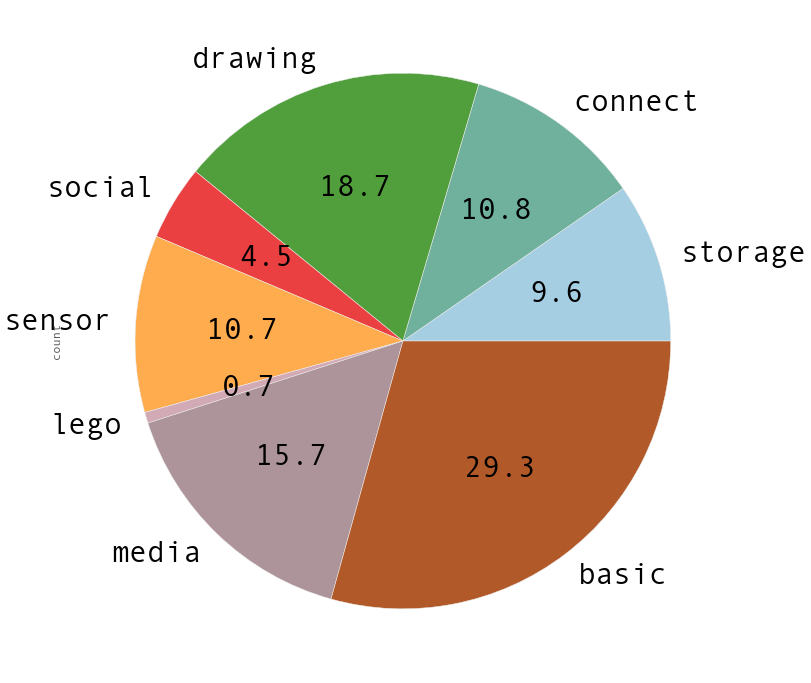

In [102]:
#Number of projects that fit into each palette group

#(ignoring all overlap, so some projects double counted)
data = {'group':cat_to_comps.keys(),
       'count': []} #supposed to be named 'count' or something but that shows up on pie chart

num_unique = {}

group_names = ['storage','connect', 'drawing', 'social', 'sensor', 'lego', 'media', 'basic']

for name in group_names:
# for val in data['group']:
    val = name
    count = df_this[df_this.palette_groups.str.contains(val)]['palette_groups'].count()
    data['count'].append(count)

# data 
# df_count = pd.DataFrame(data=data['count'], index=data['group'], columns=['count'])
df_count = pd.DataFrame(data=data['count'], index=group_names, columns=['count'])

df_count_t = df_count.transpose()
# print df_count_t.values.sum()
# df_count_t.plot(kind='barh', stacked=True, figsize=(12,4))
plot = df_count.plot(kind='pie', subplots=True, figsize=(12,12), legend=False, fontsize=30, colormap='Paired', autopct='%.1f')
print df_count.values.sum() #number of categories projects fit into


In [96]:
#separating df by group (overlap exists)

agg_cols = ['agg_basic', 'agg_lego', 'agg_media', 'agg_storage', 'agg_connect', 'agg_social', 'agg_sensor', 'agg_drawing']

df_basic = df_this[df_this.agg_lego==0][df_this.agg_media==0][df_this.agg_storage==0][df_this.agg_connect==0][df_this.agg_social==0][df_this.agg_sensor==0][df_this.agg_drawing==0].reset_index()
df_lego = df_this[df_this.agg_lego>0].reset_index()
df_media = df_this[df_this.agg_media>0].reset_index()
df_storage = df_this[df_this.agg_storage>0].reset_index()
df_connect = df_this[df_this.agg_connect>0].reset_index()
df_social = df_this[df_this.agg_social>0].reset_index()
df_sensor = df_this[df_this.agg_sensor>0].reset_index()
df_draw = df_this[df_this.agg_drawing>0].reset_index()
df_all = df_this.reset_index()

27

In [115]:
num_projects = len(df_this) 
num_projects_single = len(df_this[~df_this.palette_groups.str.contains(',')]) #number of projects put into 1 palette group
num_groupings = df_count.values.sum() #number of groups projects fit into

print num_projects
print num_projects_single
print num_groupings

print float(num_projects_single)/num_projects
print 1.-float(num_projects_single)/num_projects

3204
2534
4116
0.79088639201
0.20911360799


In [84]:
#make sure these align!
groups = [df_all, df_storage, df_connect, df_draw, df_social, df_sensor, df_lego, df_media, df_basic]
group_names = ['all', 'storage','connect', 'drawing', 'social', 'sensor', 'lego', 'media', 'basic']

agg_groups = {'all': df_all,
             'basic': df_basic,
             'lego': df_lego,
             'media': df_media,
             'storage': df_storage,
             'connect': df_connect,
             'social': df_social,
             'sensor': df_sensor,
             'drawing': df_draw,
             }
 
#new dataframe where each group is column (rows don't correspond to anything really)
df_groups = pd.DataFrame()
df_groups_f = pd.DataFrame()
counter = 0
# for ignore, agg_df in agg_groups.iteritems():
#     name = ignore
for agg_df in groups:
    name = group_names[counter] # need this to ensure columns of graphs same order
    col = agg_df['num_blocks_unique']
    df_groups.insert(len(df_groups.columns), name, col)
    
    #Sanity check (had this issue, resolved by calling reset_index() for df_all)
    if len(col)!=len(df_groups[name].dropna()):
        print 'WARNING: Not all projects being transferred to df_groups'
    counter+=1
# print 'all'
# df_groups.insert(len(df_groups.columns), 'all', agg_all['num_blocks_unique']                 
# df_groups.to_csv("temp.csv")
print df_groups.head(3)    

    all  storage  connect  drawing  social  sensor  lego  media  basic
0  3.00    19.00    18.00     3.00   12.00   18.00  5.00   5.00   8.00
1  8.00     3.00    12.00    17.00    5.00    3.00  5.00  18.00   3.00
2 17.00    17.00     5.00     4.00   22.00   13.00  3.00  13.00   6.00


In [56]:
# df_storage[df_storage.num_blocks_unique==47]
# df_storage['num_blocks_unique'].max()
# df_groups.storage.max()

# df_temp = df_this[df_this.palette_groups=='conn'][['project_name', 'palette_groups']]
# for i in range(100):
#     print df_temp['project_name'].iloc[i]


In [86]:
# save_agg_dfs(df, df_count, df_groups, "omit", "SOMETHING")
df_groups.describe()

#trying to get outliers...failed...
# upper = df_groups.transform(lambda x: x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )


,all,storage,connect,drawing,social,sensor,lego,media,basic
count,"3,204.00",401.00,463.00,771.00,192.00,448.00,27.00,655.00,"1,207.00"
mean,9.25,15.55,12.35,11.23,10.60,9.99,8.04,8.37,7.50
std,7.13,9.75,8.78,6.83,8.95,7.57,4.86,7.07,5.80
min,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,4.00,8.00,6.00,6.00,4.00,4.00,5.00,3.00,3.00
50%,7.00,14.00,10.00,10.00,8.00,8.00,7.00,6.00,6.00
75%,13.00,21.00,17.00,15.50,16.00,14.00,10.00,11.00,11.00
max,56.00,56.00,56.00,38.00,44.00,44.00,22.00,56.00,44.00


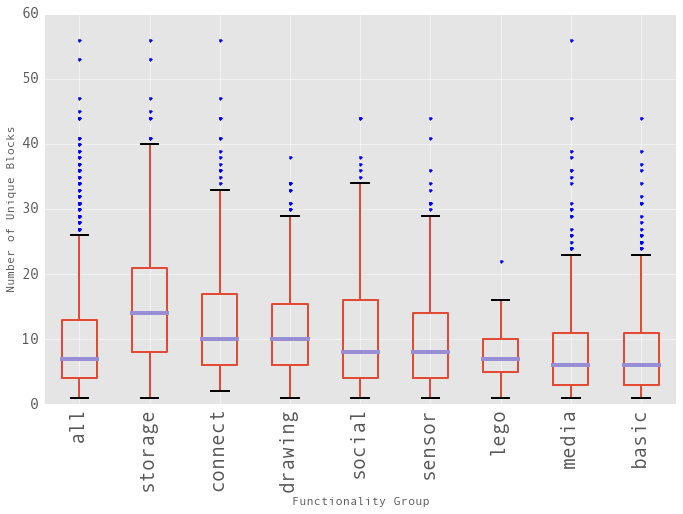

In [60]:
# df_groups.plot(kind='box', figsize=(11.326,7), sym='b.', rot= 90, fontsize=20)

fig = plt.figure(figsize=(11.326,7))
ax, bp = df_groups.boxplot(return_type='both')
plt.set_cmap('Paired')
plt.setp(bp['boxes'], lw=2)
plt.setp(bp['whiskers'], lw=2, linestyle='solid')
plt.setp(bp['medians'], lw=4)
plt.setp(bp['caps'], lw=2)
plt.setp(bp['fliers'], marker='.')
plt.set_cmap('Paired')
ax.set_xlabel('Functionality Group')
ax.set_ylabel('Number of Unique Blocks')
ax.set_xticklabels(df_groups.columns, rotation=90, fontsize=20)
ax.set_yticklabels(range(0,61,10), fontsize=15)

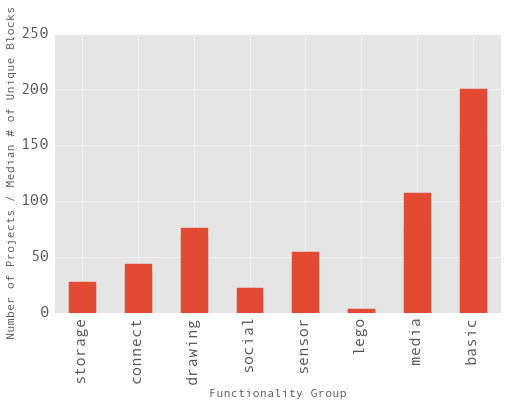

In [95]:
#relationship between intricacy and # of projects by group

df_test = df_count.copy()
s = df_test.sum()
s.name = 'all'
df_test = df_test.append(s)
df_test['avg'] = df_groups.mean()
df_test['med'] = df_groups.median()
df_test = df_test.drop('all')

# df_test
# df_groups[~['all']]
df_ratio = df_test['count'] / df_test['avg']
plot = df_ratio.plot(kind='bar', figsize=(8,5), fontsize=16,)
plot.set_ylabel('Number of Projects / Mean # of Unique Blocks')
plot.set_xlabel('Functionality Group')

df_ratio2 = df_test['count'] / df_test['med']
plot = df_ratio2.plot(kind='bar', figsize=(8,5), fontsize=16,)
plot.set_ylabel('Number of Projects / Median # of Unique Blocks')
plot.set_xlabel('Functionality Group')

# df_ratio.plot(kind='bar', x='c', y='d', color='DarkGreen');

# df_ratio_med = df_test['count'] / df_test['med']
# df_ratio_med.plot(kind='bar')

# df_ratio_2 = df_test['avg'] / df_test['count']
# df_ratio_2.plot(kind='bar')


#LEARNABILITY

In [33]:
#ratio to measure learnability, capability
tmp = pd.DataFrame(data=df_groups.describe())
low = tmp.loc['25%',:]- tmp.loc['min',:]
iqr = tmp.loc['75%',:] - tmp.loc['25%',:]

ratio = 2.5*iqr / low #normalize somehow to get this to work

#results not very definitive of anything (lego and storage next to each other...yikes)
# ratio.plot(kind='bar')

In [34]:
#Pearson Mode Skewness
skew = (df_groups.mean() - df_groups.median()) / df_groups.std()
skew.sort(ascending=True)
# skew.plot(kind='bar')
print skew

#Pearson Mode Skewness, Alternative
# 3*(df_groups.mean() - df_groups.median()) / df_groups.std()


storage    0.159307
drawing    0.180574
lego       0.213582
basic      0.259025
sensor     0.263141
connect    0.267447
social     0.290362
all        0.316080
media      0.334845
dtype: float64


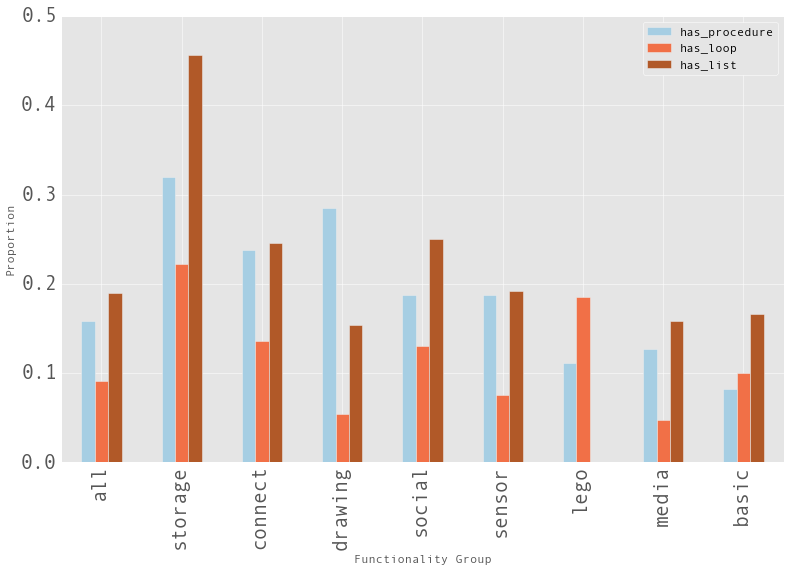

In [85]:
# groups = [df_all, df_basic, df_lego, df_media, df_storage, df_connect, df_social, df_sensor, df_draw]
# group_names = ['all', 'basic', 'lego', 'media', 'storage', 'connect', 'social', 'sensor', 'draw']

#new dataframe where each group is column (rows don't correspond to anything really)
df_mult = pd.DataFrame(columns = mult_cols, index=group_names)

for i in range(len(groups)):
    group_name = group_names[i] #basic, lego
    df_temp = groups[i] #df of specific group
    for j in range(len(mult_cols)): #0-2
        mult_name = mult_cols[j]
        frac = float(df_temp[mult_name].sum()) / float(len(df_temp)) #frac of projects that has multiplier
        df_mult.loc[group_names[i], mult_name] = frac

        
cmap = 'Paired'
plot = df_mult.plot(kind='bar', figsize=(12.944,8), fontsize=20, colormap=cmap)
plot.set_xlabel('Functionality Group')
plot.set_ylabel('Proportion')
        
#looping through colormaps to find one that looks good in gray scale
# qual=['Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3']        
# for val in qual:
#     df_mult.plot(kind='bar', figsize=(12.944,8), fontsize=20, colormap=val, title=val)

Looking at Outlier Projects

In [80]:
#figuring out project w/ most num unique blocks
#it's a password keeper!!! "v2_67"
# max_unique = df_this['num_blocks_unique'].max()

# df_max = df_this[df_this['num_blocks_unique']==max_unique]
# df_max[['palette_groups']+agg_cols]
#69 total
#getting all outlier projects
df_outlier = df_this[np.abs(df_this.num_blocks_unique-df_this.num_blocks_unique.mean())>=(3*df_this.num_blocks_unique.std())]
# df_outlier[['project_name', 'num_components', 'num_blocks', 'num_blocks_unique', 'palette_groups', 'num_palette_groups' ]]
# df_outlier.groupby(df_outlier.palette_groups)

In [37]:
#Determmining which components appear most in multiple groups

#list of all columns refering to blocks or components
# blocks = [name for name in df.columns if name[:2]=="b_"] #111 total
# components = [name for name in df.columns if name[:2]=="c_"] #57 total

# count = df[df.num_palette_groups>1][components].apply(lambda column: (column!=0).sum())
# count.sort(ascending=False)
# count

In [38]:
iqr  = 0.6745 #fraction of std deviation = 1 quartile
# (df_groups.median()+(2.698+0.7*df_groups.std()) / (0.6745*df_groups.std())
# df_groups.quantile(q=0.99)
# /df_groups.quantile(q=0.25)

In [39]:
# df[['num_palette_groups']].hist()
# df[df.num_palette_groups>1]['num_palette_groups'].hist()

3204
basic              1207
drawing             501
media               286
connect             224
storage             145
media,sensor         92
sensor,drawing       91
sensor               91
media,drawing        70
social               53
storage,connect      40
storage,drawing      28
media,connect        28
lego                 27
media,storage        26
dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11072fe10>], dtype=object)

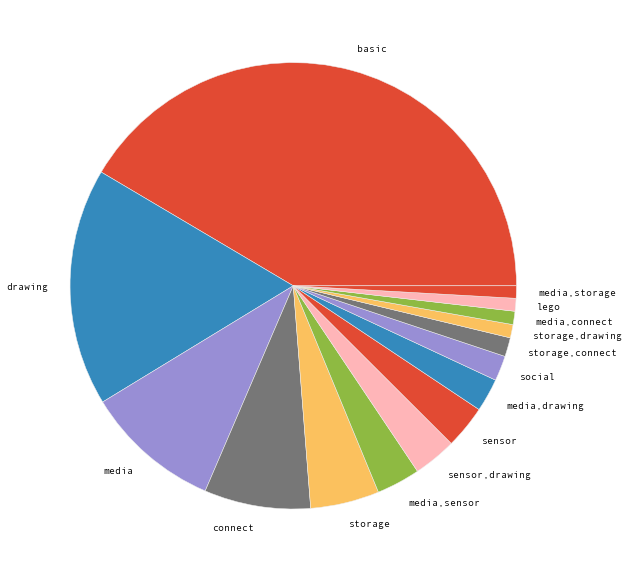

In [99]:
count = df_this['palette_groups'].value_counts()
print count.sum()
print count.head(15)
count.head(15).plot(kind='pie', subplots=True, figsize=(10,10))

In [100]:
#% of each group
NUM_PROJS = len(df_this)
# for key in count.keys:
#     count[keys] = count[keys] / NUM_PROJS
sum=0
i = 0;
for key, val in count.iteritems():
    if i<15:
        sum+=val
    i=i+1
    print key + "\t" + str(val) + "\t" + str(float(val)/NUM_PROJS)
#     "%.2f" % a
print i
print sum
print float(sum)/NUM_PROJS

basic	1207	0.376716604245
drawing	501	0.156367041199
media	286	0.0892634207241
connect	224	0.0699126092385
storage	145	0.0452559300874
media,sensor	92	0.0287141073658
sensor,drawing	91	0.0284019975031
sensor	91	0.0284019975031
media,drawing	70	0.021847690387
social	53	0.0165418227216
storage,connect	40	0.0124843945069
storage,drawing	28	0.00873907615481
media,connect	28	0.00873907615481
lego	27	0.00842696629213
media,storage	26	0.00811485642946
storage,connect,sensor	25	0.00780274656679
media,sensor,drawing	23	0.00717852684145
connect,sensor	20	0.00624219725343
storage,sensor	19	0.00593008739076
storage,social	19	0.00593008739076
media,social	18	0.00561797752809
media,storage,connect	17	0.00530586766542
connect,social	12	0.00374531835206
media,storage,drawing	11	0.00343320848939
media,storage,social	10	0.00312109862672
social,sensor	8	0.00249687890137
media,connect,sensor	8	0.00249687890137
media,connect,social	8	0.00249687890137
storage,connect,social	7	0.0021847690387
media,storage,s